# Training the classifier

This notebook's role is to train our classifier on the training data. We are then able to save the best model to a file and use it in the [report](report.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch 
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F



from utils.utils import *
from utils.display import *
from utils.model_setup import CoinDataset

from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Name:", torch.cuda.get_device_name(0))  # Print the name of the GPU
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

train_folder = 'data/train_coins'
masks_folder = 'data/train_masks'

/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


GPU is not available, using CPU instead


# 3. Classification

We start by loading the training data and the labels created by the [create_dataset](create_dataset.ipynb) notebook. We also split the data into training and validation sets.

In [2]:
labels_names = ['5CHF', '2CHF', '1CHF', '0.5CHF', '0.2CHF', '0.1CHF', '0.05CHF',
       '2EUR', '1EUR', '0.5EUR', '0.2EUR', '0.1EUR', '0.05EUR', '0.02EUR',
       '0.01EUR', 'OOD']

images = load_images_from_folder(train_folder,resize=False)
masks = load_images_from_folder(masks_folder,resize=False)

data = pd.read_csv(train_folder+'/labels.csv')
labels = data['labels'].values
y = [labels_names.index(label) for label in labels]

x_train, x_val, y_train, y_val, masks_train, masks_val = train_test_split(images, y, masks, seed=0, ratio=0.79)
masks_train = [masks_train[i].astype(np.bool_)[...,0] for i in range(len(masks_train))]
masks_val = [masks_val[i].astype(np.bool_)[...,0] for i in range(len(masks_val))]

For our model, we make use of the ResNet-50 model pretrained on the ImageNet-1k dataset. We remove the last layer and add two new linear layers with a ReLU activation function and some dropout. The last layer has one neurone for each possible coin class. We freeze the weights of the pre-trained layers to make use of ResNet's feature extraction capabilities only train the last two layers for classification.

In [3]:
num_classes = 16  # number of coin types
augment = True

def init(module, weight_init, bias_init, gain=1):
    '''
    This function provides weight and bias initializations for linear layers.
    '''
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

init_ = lambda m: init(m, nn.init.xavier_normal_, lambda x: nn.init.constant_(x, 0), np.sqrt(2))

## Resnet 50 model (finally not used here)

In [4]:
# # Load pre-trained ResNet-50 model
# model = models.resnet50(weights="IMAGENET1K_V2")


# # Replace the last fully connected layer
# model.fc = torch.nn.Sequential(init_(nn.Linear(model.fc.in_features, num_classes*100)),
#                                nn.BatchNorm1d(num_classes*100),
#                                nn.ReLU(),
#                                nn.Dropout(0.5),
#                                init_(nn.Linear(num_classes*100, num_classes*10)),
#                                nn.BatchNorm1d(num_classes*10),
#                                nn.ReLU(),
#                                nn.Dropout(0.5),
#                                init_(nn.Linear(num_classes*10, num_classes)))

# # Freeze all layers except the last fully connected layer
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# for param in model.fc.parameters():
#     param.requires_grad = True
# trainable_parameters = model.fc.parameters()

## Efficientnet B0 model

In [5]:
# Load pre-trained efficient-net B0 model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)#models.efficientnet_b0(pretrained=True)#
# model#.features[8]#classifier
model.classifier.fc = torch.nn.Sequential(init_(nn.Linear(model.classifier.fc.in_features, num_classes*100)),
                                        nn.BatchNorm1d(num_classes*100),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        init_(nn.Linear(num_classes*100, num_classes*50)),
                                        nn.BatchNorm1d(num_classes*50),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        init_(nn.Linear(num_classes*50, num_classes*10)),
                                        nn.BatchNorm1d(num_classes*10),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        init_(nn.Linear(num_classes*10, num_classes)))

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.classifier.parameters():
    param.requires_grad = True
# Unfreeze the last layer
for param in model.features.parameters():
    param.requires_grad = True
    
trainable_parameters = list(model.classifier.parameters()) + list(model.features.parameters())

Using cache found in /home/avray/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/avray/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/avray/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [6]:
model

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [7]:
batch_size = 16
random.seed(42)

# Assuming you have a directory with 'train' and 'val' subdirectories
train_dataset = CoinDataset(x_train, masks_train, y_train, is_validation=False, augment=True) #augmentation implies rotation, translation, color change, ...
valid_dataset = CoinDataset(x_val,masks_val, y_val, is_validation=True)


train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [8]:
save_path = 'data/efficientb0.ckpt'

# read best_val_accuracy.ckpt
if os.path.exists('data/best_val_accuracy.ckpt'):
    overall_best_val_accuracy = torch.load('data/best_val_accuracy.ckpt')
    print(f'Validation accuracy to beat: {overall_best_val_accuracy}')
else:
    overall_best_val_accuracy = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainable_parameters, lr=1e-3)  # Optimize only the last layer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train the model (aprroximately 20 minutes on cpu)
model.train()
n_epochs = 100

best_val_accuracy = 0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch')

    losses = []
    correct_train = 0
    total_train = 0

    for batch_idx, (features, labels) in enumerate(progress_bar):

        optimizer.zero_grad() #set gradient to zero before starting
    
        
        preds = model(features)
        loss = F.cross_entropy(preds, labels)

        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(preds.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        train_accuracy =  correct_train / total_train

        losses.append(loss.item())
        epoch_train_loss = np.mean(losses)

        progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy)


        if batch_idx == len(train_loader) - 1:
            # Calculate validation set accuracy
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images,labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_accuracy =  correct_val / total_val
            if val_accuracy >= best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_epoch = epoch+1
                torch.save(model.state_dict(), save_path)
                if best_val_accuracy >= overall_best_val_accuracy:
                    overall_best_val_accuracy = best_val_accuracy
                    torch.save(model.state_dict(), 'data/best_model.ckpt')
                    torch.save(model, 'data/best_model.pth')
                    torch.save(best_val_accuracy, 'data/best_val_accuracy.ckpt')
                    print(f'This model is your best model with accuracy: {best_val_accuracy} at epoch: {best_epoch}')

        #     # Save metrics
            train_losses.append(epoch_train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Update progress bar postfix with validation set accuracy
            progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy)    

    scheduler.step()  

Epoch 1/100: 100%|██████████| 19/19 [00:15<00:00,  1.22batch/s, loss=2.93, train_accuracy=0.186, val_accuracy=0.173]


This model is your best model with accuracy: 0.1728395061728395 at epoch: 1


Epoch 2/100: 100%|██████████| 19/19 [00:14<00:00,  1.29batch/s, loss=2.32, train_accuracy=0.299, val_accuracy=0.358]


This model is your best model with accuracy: 0.35802469135802467 at epoch: 2


Epoch 3/100: 100%|██████████| 19/19 [00:17<00:00,  1.07batch/s, loss=1.6, train_accuracy=0.429, val_accuracy=0.63]


This model is your best model with accuracy: 0.6296296296296297 at epoch: 3


Epoch 6/100: 100%|██████████| 19/19 [00:15<00:00,  1.26batch/s, loss=1.05, train_accuracy=0.654, val_accuracy=0.679]


This model is your best model with accuracy: 0.6790123456790124 at epoch: 6


Epoch 7/100: 100%|██████████| 19/19 [00:15<00:00,  1.21batch/s, loss=0.954, train_accuracy=0.678, val_accuracy=0.704]


This model is your best model with accuracy: 0.7037037037037037 at epoch: 7


Epoch 9/100: 100%|██████████| 19/19 [00:14<00:00,  1.30batch/s, loss=0.777, train_accuracy=0.701, val_accuracy=0.728]


This model is your best model with accuracy: 0.7283950617283951 at epoch: 9


Epoch 11/100: 100%|██████████| 19/19 [00:17<00:00,  1.10batch/s, loss=0.687, train_accuracy=0.787, val_accuracy=0.84]


This model is your best model with accuracy: 0.8395061728395061 at epoch: 11


Epoch 13/100: 100%|██████████| 19/19 [00:13<00:00,  1.38batch/s, loss=0.525, train_accuracy=0.794, val_accuracy=0.864]


This model is your best model with accuracy: 0.8641975308641975 at epoch: 13


Epoch 23/100: 100%|██████████| 19/19 [00:14<00:00,  1.28batch/s, loss=0.228, train_accuracy=0.924, val_accuracy=0.877]


This model is your best model with accuracy: 0.8765432098765432 at epoch: 23


Epoch 24/100: 100%|██████████| 19/19 [00:14<00:00,  1.30batch/s, loss=0.32, train_accuracy=0.874, val_accuracy=0.889]


This model is your best model with accuracy: 0.8888888888888888 at epoch: 24


Epoch 29/100: 100%|██████████| 19/19 [00:15<00:00,  1.25batch/s, loss=0.225, train_accuracy=0.924, val_accuracy=0.889]


This model is your best model with accuracy: 0.8888888888888888 at epoch: 29


Epoch 30/100: 100%|██████████| 19/19 [00:14<00:00,  1.28batch/s, loss=0.185, train_accuracy=0.927, val_accuracy=0.889]


This model is your best model with accuracy: 0.8888888888888888 at epoch: 30


Epoch 33/100: 100%|██████████| 19/19 [00:14<00:00,  1.29batch/s, loss=0.208, train_accuracy=0.937, val_accuracy=0.926]


This model is your best model with accuracy: 0.9259259259259259 at epoch: 33


Epoch 100/100: 100%|██████████| 19/19 [00:14<00:00,  1.31batch/s, loss=0.114, train_accuracy=0.95, val_accuracy=0.889]


In [9]:
print(f"Best validation accuracy: {best_val_accuracy} at epoch {best_epoch}")

Best validation accuracy: 0.9259259259259259 at epoch 33


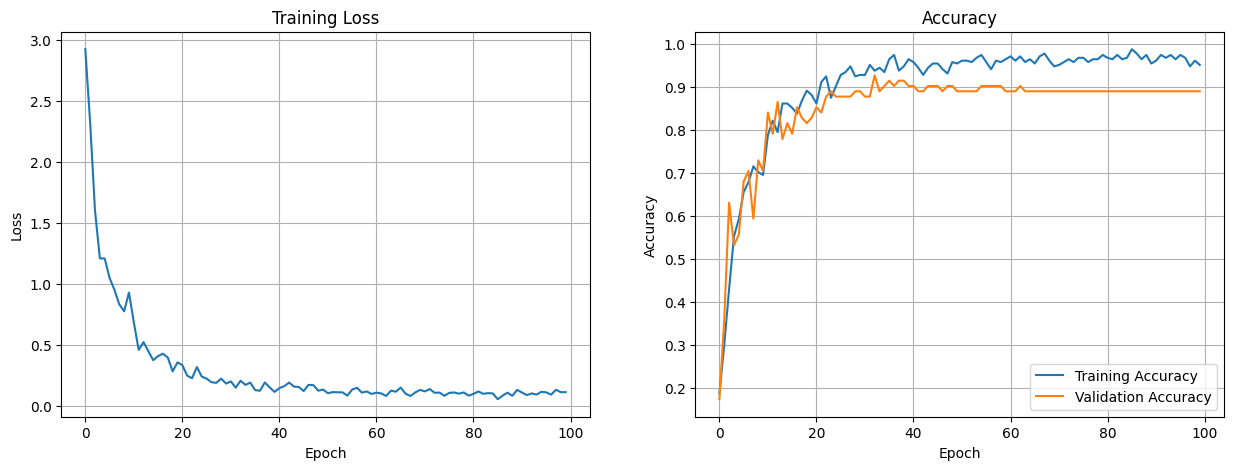

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()
plt.show()


# Observe Predictions

In [14]:
y_pred = []
model.eval()

# Iterate over the test dataset and make predictions
for images, labels in valid_loader:
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted class index
    _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)
    
    y_pred.extend(predicted.cpu().numpy())


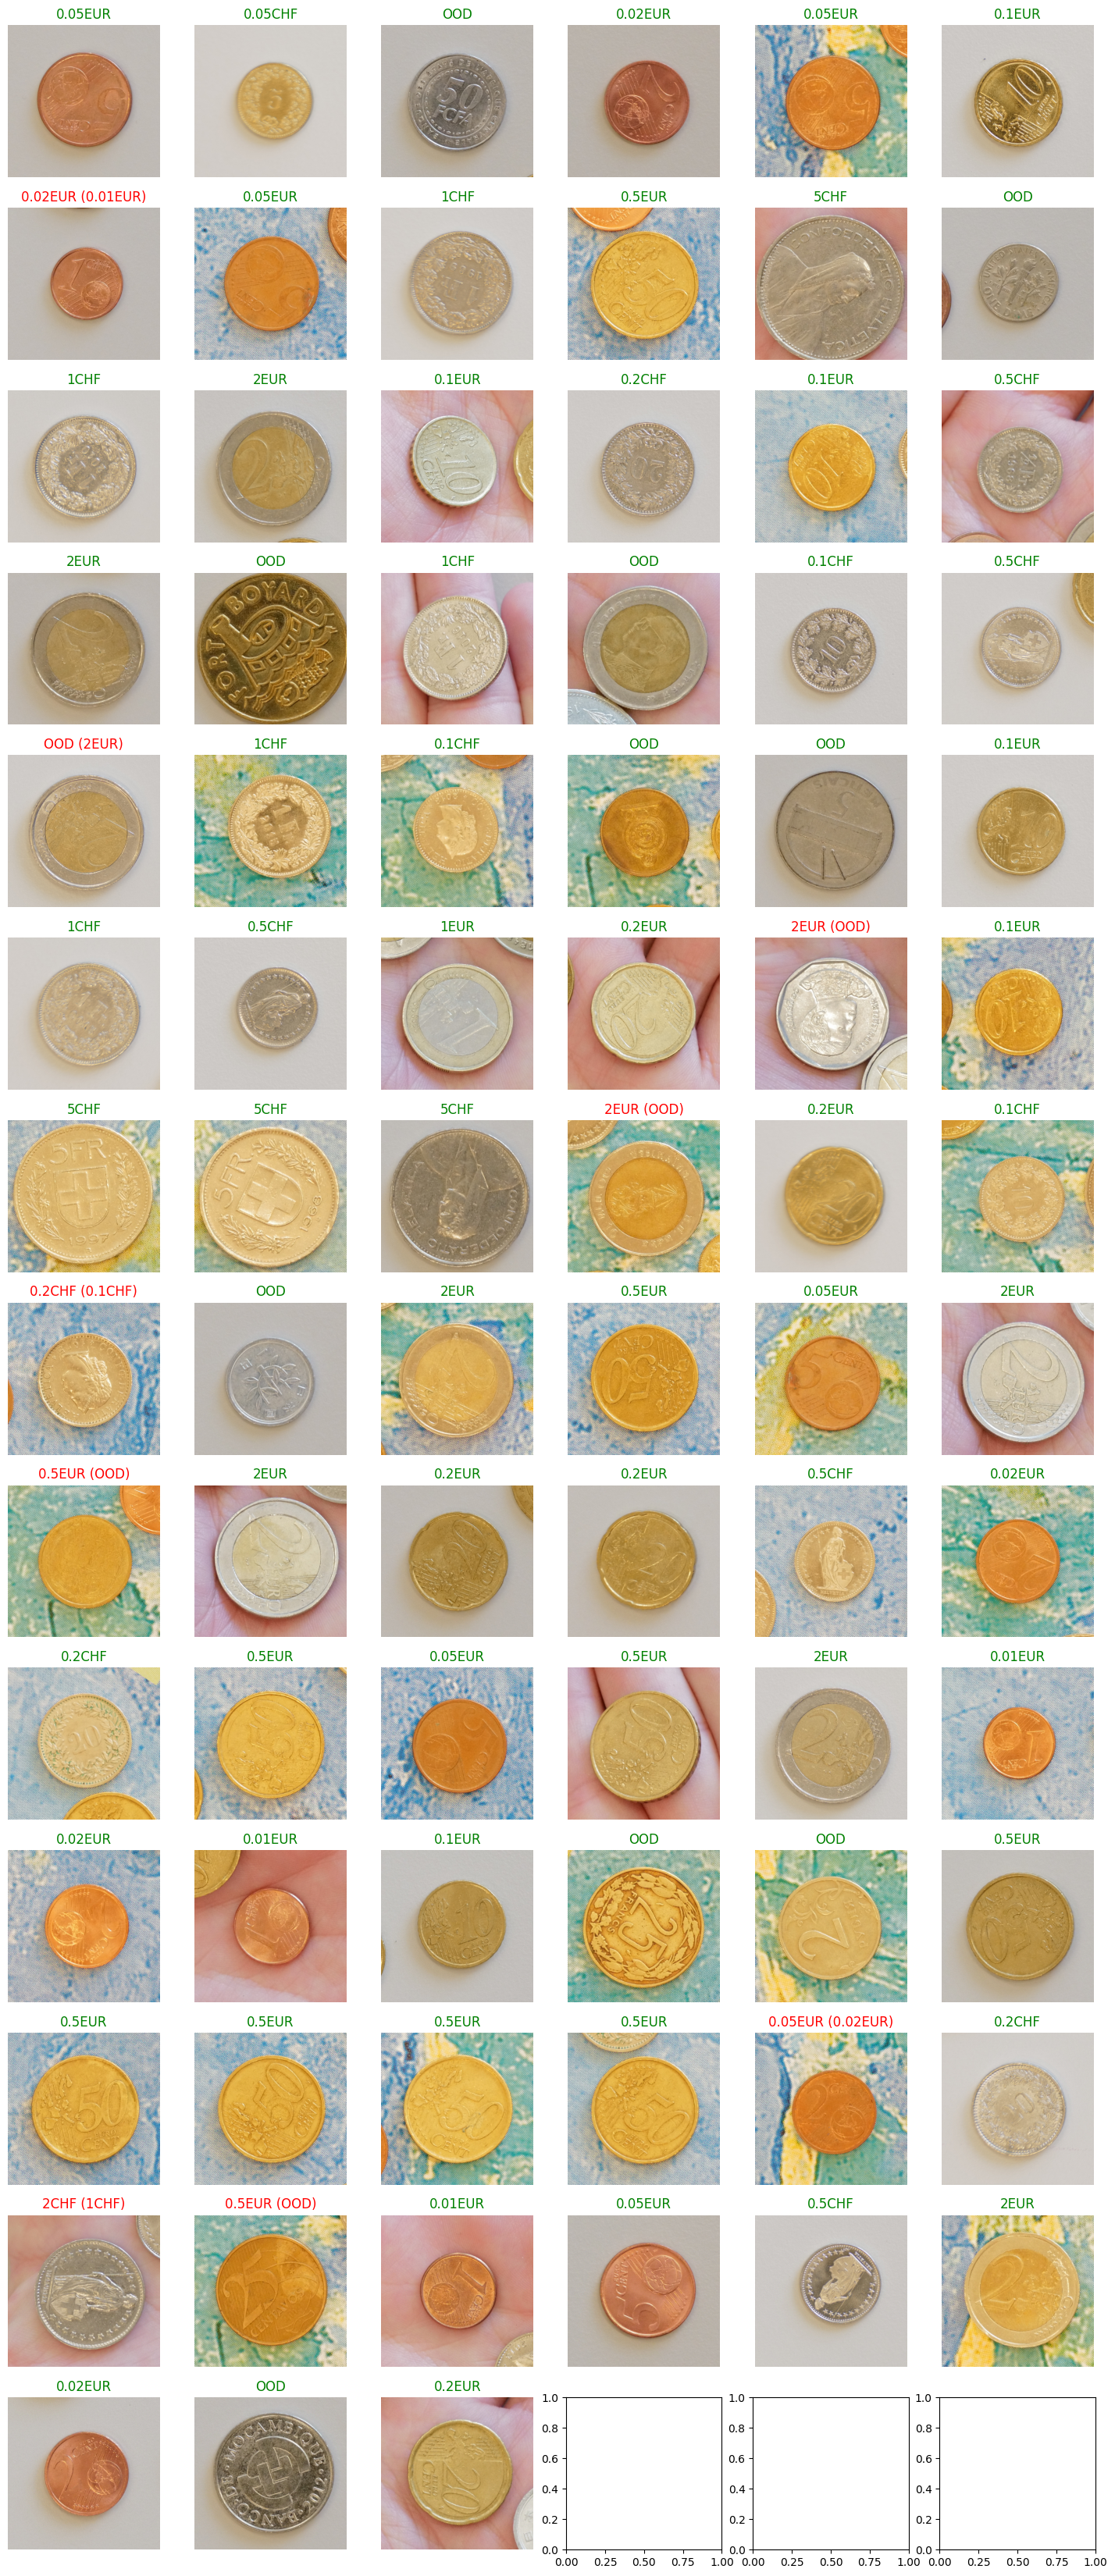

In [15]:
nbr = None
plot_coins(x_val[0:nbr], y_val[0:nbr], y_pred[0:nbr])